I'll take the same approach to modeling for tweets as I did with the headlines. I'll be using both the Multinomial Naive Bayes and Random Forests algorithm to build and evaluate model performance for both 4 classes and 5 classes.

In [1]:
#import libraries 
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

In [2]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
stopwords = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

In [4]:
twitter_df = pd.read_csv('data/nba_twitter.csv')

In [5]:
twitter_df.head()

,date,tweet,source,tweet_tokens,dual_labels,trip_labels,quad_labels,five_labels
0,2021-02-26 12:35:27,Obi Toppin is expected to participate in the N...,Yahoo,"['obi', 'toppin', 'expected', 'participate', '...",0,0,3,1
1,2021-02-25 23:08:17,MPJ SLAM,Yahoo,"['mpj', 'slam', '']",1,2,1,2
2,2021-02-25 17:48:50,Timberwolves G Malik Beasley has been suspende...,Yahoo,"['timberwolves', 'g', 'malik', 'beasley', 'sus...",1,2,1,2
3,2021-02-25 13:40:20,Luka's game-winner against the Celtics vs. Luk...,Yahoo,"['lukas', 'gamewinner', 'celtic', 'v', 'lukas'...",1,2,2,2
4,2021-02-25 13:10:50,It's time to stop underrating the Utah Jazz Fr...,Yahoo,"['time', 'stop', 'underrating', 'utah', 'jazz'...",1,2,1,2


In [6]:
twitter_df.dropna(subset=['tweet'], inplace=True)

In [7]:
twitter_df['dual_labels'].value_counts()

1    101191
0     25840
Name: dual_labels, dtype: int64

In [8]:
twitter_df['trip_labels'].value_counts()

2    94828
0    24695
1     7508
Name: trip_labels, dtype: int64

In [9]:
twitter_df['quad_labels'].value_counts()

1    93218
3    24168
2     6822
0     2823
Name: quad_labels, dtype: int64

In [10]:
twitter_df['five_labels'].value_counts()

2    96911
1    20803
4     3978
3     2715
0     2624
Name: five_labels, dtype: int64

In [13]:
def summary_scores(model, train_set_x, test_set_x, train_set_y, test_set_y, cross_val_var):
    print(f'Training Accuracy: {model.score(train_set_x, train_set_y)}')
    print(f'Cross Validation Accuracy: {np.mean(cross_val_var)}')
    print(f'Testing Accuracy: {model.score(test_set_x, test_set_y)}')
    print(f'F1 Score: {f1_score(test_set_y, model.predict(test_set_x), average="weighted")}')
    print(f'Recall: {recall_score(test_set_y, model.predict(test_set_x), average="weighted")}')
    print(f'Precision: {precision_score(test_set_y, model.predict(test_set_x), average="weighted")}')

In [12]:
X = twitter_df['tweet']
y_four = twitter_df['quad_labels']
y_five = twitter_df['five_labels']
X_train_four, X_test_four, y_train_four, y_test_four = train_test_split(X, y_four, 
                                                                        test_size=0.3, 
                                                                        stratify=y_four, random_state=123)

In [14]:
X_train_five, X_test_five, y_train_five, y_test_five = train_test_split(X, y_five, 
                                                                        test_size=0.3, 
                                                                        stratify=y_five, random_state=123)

In [15]:
vectorizer_four = TfidfVectorizer(stop_words=stopwords)
X_train_sparse_four = vectorizer_four.fit_transform(X_train_four)
X_test_sparse_four = vectorizer_four.transform(X_test_four)

In [16]:
vectorizer_five = TfidfVectorizer(stop_words=stopwords)
X_train_sparse_five = vectorizer_five.fit_transform(X_train_five)
X_test_sparse_five = vectorizer_five.transform(X_test_five)

As a reminder, when using 4 classes the topics associated with each group are:

0. Free Agency
1. LeBron, the Warriors, coaches, and highlights
2. Game Scores/Outcomes
3. NBA Draft/Rankings

For 5 classes the topics are:

0. Rankings
1. League News (keyword: 'NBA')
2. Tweets focused on individual players and their performances
3. Free Agency
4. NBA Draft

## Multinomial Naive Bayes

For the multinomial naive bayes algorithm we cannot do a PCA transformation first because the algorithm requires that all the values be positive (probabilities can only exist between the values of zero and one). We will still be using the sparse matrix as the input so the algorithm should work efficiently.

In [17]:
mnb_vanilla_four = MultinomialNB()
mnb_vanilla_four.fit(X_train_sparse_four, y_train_four)

MultinomialNB()

In [18]:
mnb_vanilla_cv = cross_val_score(mnb_vanilla_four, X_train_sparse_four, 
                                 y_train_four, cv=5, scoring='accuracy', n_jobs=-1)

In [19]:
summary_scores(mnb_vanilla_four, X_train_sparse_four, 
               X_test_sparse_four, y_train_four, y_test_four, mnb_vanilla_cv)

Training Accuracy: 0.8378448285556842
Cross Validation Accuracy: 0.8199975427492703
Testing Accuracy: 0.8243768039884545
F1 Score: 0.7864414022814671
Recall: 0.8243768039884545
Precision: 0.842552523044543


In [20]:
print(classification_report(y_test_four, mnb_vanilla_four.predict(X_test_sparse_four)))

              precision    recall  f1-score   support

           0       1.00      0.19      0.32       847
           1       0.82      0.99      0.89     27966
           2       1.00      0.04      0.07      2047
           3       0.88      0.49      0.63      7250

    accuracy                           0.82     38110
   macro avg       0.92      0.43      0.48     38110
weighted avg       0.84      0.82      0.79     38110



In [21]:
mnb_vanilla_five = MultinomialNB()
mnb_vanilla_five.fit(X_train_sparse_five, y_train_five)
mnb_vanilla_cv_five = cross_val_score(mnb_vanilla_five, 
                                      X_train_sparse_five, y_train_five, cv=5, scoring='accuracy', n_jobs=-1)

In [22]:
summary_scores(mnb_vanilla_five, X_train_sparse_five, 
               X_test_sparse_five, y_train_five, y_test_five, mnb_vanilla_cv)

Training Accuracy: 0.8496080790814319
Cross Validation Accuracy: 0.8199975427492703
Testing Accuracy: 0.8376279191813173
F1 Score: 0.8044163993692626
Recall: 0.8376279191813173
Precision: 0.8474824090824179


In [23]:
print(classification_report(y_test_five, mnb_vanilla_five.predict(X_test_sparse_five)))

              precision    recall  f1-score   support

           0       1.00      0.14      0.24       787
           1       0.86      0.36      0.50      6241
           2       0.83      1.00      0.91     29074
           3       0.99      0.21      0.34       815
           4       0.95      0.39      0.55      1193

    accuracy                           0.84     38110
   macro avg       0.93      0.42      0.51     38110
weighted avg       0.85      0.84      0.80     38110



Although we have a larger dataset, the naive bayes algorithm do slightly worse (when compared to the classification of headlines) for predicting the classes of tweets. There is a greater than 1% difference for the model trained with 5 classes so there may be some overfitting occurring. We would either need to change the size of the training and test sets or try to gather more data for the classes.

In the context of using a classification model as part of a recommendation system, the low recall scores are somewhat disappointing. In this context of a recommendation system precision is probably more important than recall but we would certainly like to have recall scores above 14% (for the 0 class) and 21% (for the 3 class). The low recall means that we have a lot of false negatives which means that users of a recommendation system might be missing out on content that they enjoy.

## Random Forests

In [24]:
pipe_rfc_vanilla_four = Pipeline([('pca', TruncatedSVD(n_components=100, random_state=23)),
                    ('rfc', RandomForestClassifier())])

pipe_rfc_vanilla_four.fit(X_train_sparse_four, y_train_four)

Pipeline(steps=[('pca', TruncatedSVD(n_components=100, random_state=23)),
                ('rfc', RandomForestClassifier())])

In [25]:
pipe_rfc_vanilla_cv_four = cross_val_score(pipe_rfc_vanilla_four, 
                                           X_train_sparse_four, y_train_four, 
                                           cv=5, scoring='accuracy', n_jobs=-1)

In [26]:
summary_scores(pipe_rfc_vanilla_four, X_train_sparse_four, X_test_sparse_four, y_train_four, 
               y_test_four, pipe_rfc_vanilla_cv_four)

Training Accuracy: 0.9999662621877846
Cross Validation Accuracy: 0.9928476032826239
Testing Accuracy: 0.9922067698766728
F1 Score: 0.992222579898552
Recall: 0.9922067698766728
Precision: 0.9922781528949008


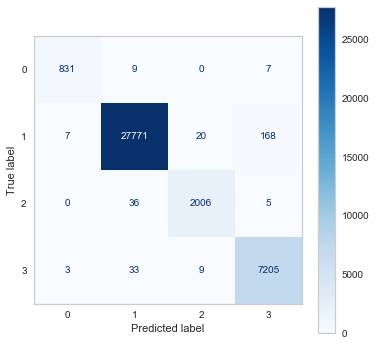

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(pipe_rfc_vanilla_four, X_test_sparse_four, y_test_four, cmap='Blues', ax=ax)
plt.savefig('tweets_random_forest_conf_matrix_4_classes.png')

In [28]:
print(classification_report(y_test_four, pipe_rfc_vanilla_four.predict(X_test_sparse_four)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       847
           1       1.00      0.99      1.00     27966
           2       0.99      0.98      0.98      2047
           3       0.98      0.99      0.98      7250

    accuracy                           0.99     38110
   macro avg       0.99      0.99      0.99     38110
weighted avg       0.99      0.99      0.99     38110



In [29]:
pipe_rfc_vanilla_five = Pipeline([('pca', TruncatedSVD(n_components=100, random_state=23)),
                                 ('rfc', RandomForestClassifier())])
pipe_rfc_vanilla_five.fit(X_train_sparse_five, y_train_five)

Pipeline(steps=[('pca', TruncatedSVD(n_components=100, random_state=23)),
                ('rfc', RandomForestClassifier())])

In [30]:
pipe_rfc_vanilla_cv_five = cross_val_score(pipe_rfc_vanilla_five, X_train_sparse_five, y_train_five,
                                          cv=5, n_jobs=-1, scoring='accuracy')

In [31]:
summary_scores(pipe_rfc_vanilla_five, X_train_sparse_five, X_test_sparse_five, y_train_five, 
               y_test_five, pipe_rfc_vanilla_cv_five)

Training Accuracy: 0.9999662621877846
Cross Validation Accuracy: 0.9915430377411202
Testing Accuracy: 0.9910784570978746
F1 Score: 0.991059081315705
Recall: 0.9910784570978746
Precision: 0.9910944571764467


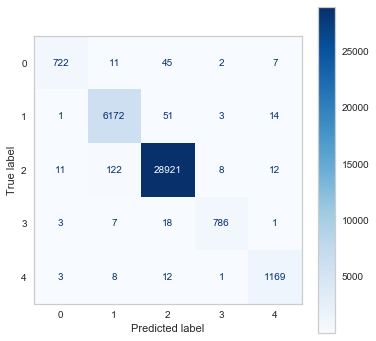

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(pipe_rfc_vanilla_five, X_test_sparse_five, y_test_five, cmap='Blues', ax=ax)
plt.savefig('tweets_random_forest_conf_matrix_5_classes.png')

In [33]:
print(classification_report(y_test_five, pipe_rfc_vanilla_five.predict(X_test_sparse_five)))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       787
           1       0.98      0.99      0.98      6241
           2       1.00      0.99      1.00     29074
           3       0.98      0.96      0.97       815
           4       0.97      0.98      0.98      1193

    accuracy                           0.99     38110
   macro avg       0.98      0.97      0.97     38110
weighted avg       0.99      0.99      0.99     38110



The random forest models for both 4 and 5 classes perform much better across for accuracy, precison, and recall. The testing accuracy is nearly identical to the cross validation training accuracy so we don't suffer from overfitting.  In the context of a recommendation system, the high precision and recall scores would mean that users are going to get the exact type of content that they want to see. This is important because it would help to prevent something like customer churn. Given that the accuracy is very high for this model, further testing would be necssary using new data that wasn't used as part of the clustering algorithm.

## Conclusion

As with headlines, the random forest algorithm seems to be the better of the two algorithms in terms of classifying the topics and is recommended if a model were to be put into production.

It's best to take a top down approach when identifying topics within NBA discourse. Model performance does suffer slightly when there are a greater number of topics (which is expected), so it is better to start broad and become more granular only as necessary. More data has to be collected as we become more granular because more specificity leads to fewer examples per class.

Free agency and the NBA Draft are two major topics that were found using both four and 5 clusters. Although the offseason won't garner the same attention as the regular season or playoffs, the NBA and its media partners should think of ways of how to market the draft and free agency to the casual fan. There were more tweets related to the draft/free agency than rankings, so we might look to promote these events more to increase engagement over the entire year. 